In [ ]:
!pip install transformers torchtext nltk rouge_score --quiet


In [53]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


In [54]:
# Environment setup
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import kagglehub
import os, glob
import pandas as pd
from tqdm import tqdm
import re

import gradio as gr


In [ ]:
# Download and get data
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_USERNAME'] = 'zelinli515'
os.environ['KAGGLE_KEY']      = '2cbc5ce9c5cc3166f35fe1e20c75da6a'
!mkdir -p /content/drive/MyDrive/all_news
!kaggle datasets download -d davidmckinley/all-the-news-dataset \
    -p /content/drive/MyDrive/all_news --unzip

DATA_DIR = "/content/drive/MyDrive/all_news"
csv_files = glob.glob(f"{DATA_DIR}/*.csv")
df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/davidmckinley/all-the-news-dataset
License(s): unknown
 99% 3.12G/3.16G [01:01<00:00, 185MB/s]
100% 3.16G/3.16G [01:01<00:00, 55.2MB/s]


<ipython-input-5-52841842b75f>:12: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)


In [ ]:
# Setup
nltk.download('punkt')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LEN_ARTICLE = 512
MAX_LEN_HEADLINE = 32
BATCH_SIZE = 8
EMBED_DIM = 256
NUM_LAYERS = 2
LR = 5e-4
EPOCHS = 10
TRANSFORMER_HEADS = 8

TRANSFORMER_LAYERS = 2
HIDDEN_SIZE         = 256
TRANSFORMER_FF      = 512
DROPOUT_RATE        = 0.0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Clean the data, only use random 15000 rows
SUBSET_SIZE = 15000
df = df.sample(n=SUBSET_SIZE, random_state=SEED).reset_index(drop=True)
df = df.dropna(subset=["title", "article"])[["article", "title"]]
df["article"] = df["article"].str.replace(r"\s+", " ", regex=True).str.strip()
df["title"] = df["title"].str.replace(r"\s+", " ", regex=True).str.strip()
df = df[df["title"].str.len() > 0].reset_index(drop=True)
df = df[df["article"].str.len() > 0].reset_index(drop=True)



In [ ]:
# Split train, val, test
train_df, test_df = train_test_split(df, test_size=0.10, random_state=SEED, shuffle=True)
train_df, val_df  = train_test_split(train_df, test_size=0.10, random_state=SEED, shuffle=True)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 11694 | Val: 1300 | Test: 1444


In [39]:
# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"bos_token":"<BOS>", "eos_token":"<EOS>", "sep_token":"<SEP>"})
tokenizer.add_special_tokens({"pad_token":"<PAD>"})
PAD = tokenizer.pad_token_id
BOS = tokenizer.bos_token_id
EOS = tokenizer.eos_token_id
SEP = tokenizer.sep_token_id
tokenizer.padding_side = "left"

In [ ]:
# Dataset for Seq2Seq and Transformer
class Seq2SeqDataset(Dataset):
    def __init__(self, df):
        self.articles = df["article"].tolist()
        self.heads    = df["title"].tolist()

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        art = self.articles[idx]
        hl  = self.heads[idx]
        # tokenize article
        enc = tokenizer(
            art,
            max_length=MAX_LEN_ARTICLE,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        # tokenize headline with BOS/EOS
        tgt = tokenizer(
            "<BOS> " + hl + " <EOS>",
            max_length=MAX_LEN_HEADLINE,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = tgt["input_ids"].squeeze(0)
        # prepare decoder inputs & shifted labels
        decoder_input_ids = labels[:-1].clone()
        decoder_labels    = labels[1:].clone()
        decoder_labels[decoder_labels == PAD] = -100
        return {
            "input_ids":         input_ids,
            "attention_mask":    attention_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_labels":    decoder_labels
        }

In [ ]:
# Dataset for GPT-2 fine-tuning
class GPT2HeadlineDataset(Dataset):
    def __init__(self, df):
        self.articles = df["article"].tolist()
        self.heads    = df["title"].tolist()

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        art = self.articles[idx]
        hl  = self.heads[idx]
        # build sequence: BOS + article + SEP + headline + EOS
        seq = "<BOS> " + art + " <SEP> " + hl + " <EOS>"
        enc = tokenizer(
            seq,
            max_length=MAX_LEN_ARTICLE + MAX_LEN_HEADLINE,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        # ignore loss on article + <SEP>
        sep_positions = (input_ids == SEP).nonzero(as_tuple=True)[0]
        sep_index = sep_positions[0].item() if len(sep_positions)>0 else MAX_LEN_ARTICLE + MAX_LEN_HEADLINE

        labels[: sep_index+1 ] = -100
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# create datasets and loaders
train_s2s = Seq2SeqDataset(train_df)
val_s2s   = Seq2SeqDataset(val_df)
test_s2s  = Seq2SeqDataset(test_df)
train_loader = DataLoader(train_s2s, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
val_loader   = DataLoader(val_s2s,   batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_s2s,  batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

train_gpt2_ds = GPT2HeadlineDataset(train_df)
val_gpt2_ds   = GPT2HeadlineDataset(val_df)
test_gpt2_ds  = GPT2HeadlineDataset(test_df)


In [ ]:
# Seq2Seq LSTM Baseline
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_size, num_layers):
        super().__init__()
        self.embed_enc = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.encoder   = nn.LSTM(emb_dim, hid_size, num_layers,
                                 batch_first=True, bidirectional=True)
        self.embed_dec = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.decoder   = nn.LSTM(emb_dim, hid_size*2, num_layers, batch_first=True)
        self.out_proj  = nn.Linear(hid_size*2, vocab_size)

    def forward(self, input_ids, attention_mask,
                decoder_input_ids):
        # encoder
        emb = self.embed_enc(input_ids)
        lengths = attention_mask.sum(-1)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, c) = self.encoder(packed)
        # init decoder state
        h0 = torch.cat([h[-2], h[-1]], dim=-1).unsqueeze(0).repeat(NUM_LAYERS,1,1)
        c0 = torch.cat([c[-2], c[-1]], dim=-1).unsqueeze(0).repeat(NUM_LAYERS,1,1)
        # decoder
        emb_dec, _ = self.decoder(self.embed_dec(decoder_input_ids), (h0, c0))
        logits = self.out_proj(emb_dec)
        return logits

def train_seq2seq():
    model = Seq2SeqLSTM(len(tokenizer), EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    best_val = float('inf')
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Seq2Seq]"):
            optim.zero_grad()
            logits = model(
                batch["input_ids"].to(DEVICE),
                batch["attention_mask"].to(DEVICE),
                batch["decoder_input_ids"].to(DEVICE)
            )
            loss = loss_fn(
                logits.view(-1, logits.size(-1)),
                batch["decoder_labels"].to(DEVICE).view(-1)
            )
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            total_loss += loss.item()
        avg_train = total_loss / len(train_loader)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                logits = model(
                    batch["input_ids"].to(DEVICE),
                    batch["attention_mask"].to(DEVICE),
                    batch["decoder_input_ids"].to(DEVICE)
                )
                val_loss += loss_fn(
                    logits.view(-1, logits.size(-1)),
                    batch["decoder_labels"].to(DEVICE).view(-1)
                ).item()
        avg_val = val_loss / len(val_loader)
        print(f"[Seq2Seq] Epoch {epoch} Train loss: {avg_train:.4f} | Val loss: {avg_val:.4f}")

        # save best
        if avg_val < best_val:
            best_val = avg_val
            torch.save(model.state_dict(), "best_seq2seq.pth")
    return model


In [ ]:
# Transformer Encoder-Decoder
class TransformerEncoderBlock(nn.Module):
    def __init__(self, hid, heads, ff_dim, dropout=DROPOUT_RATE):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(hid, heads, batch_first=True)
        self.dropout1  = nn.Dropout(dropout)
        self.norm1     = nn.LayerNorm(hid)

        self.ff        = nn.Sequential(
            nn.Linear(hid, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, hid)
        )
        self.dropout2  = nn.Dropout(dropout)
        self.norm2     = nn.LayerNorm(hid)

    def forward(self, x, src_key_padding_mask):
        attn_out, _ = self.self_attn(
            x, x, x,
            key_padding_mask=src_key_padding_mask
        )
        x = x + self.dropout1(attn_out)
        x = self.norm1(x)
        ff_out = self.ff(x)
        x = x + self.dropout2(ff_out)
        x = self.norm2(x)
        return x


class TransformerDecoderBlock(nn.Module):
    def __init__(self, hid, heads, ff_dim, dropout=DROPOUT_RATE):
        super().__init__()
        self.self_attn  = nn.MultiheadAttention(hid, heads, batch_first=True)
        self.dropout1   = nn.Dropout(dropout)
        self.norm1      = nn.LayerNorm(hid)

        self.cross_attn = nn.MultiheadAttention(hid, heads, batch_first=True)
        self.dropout2   = nn.Dropout(dropout)
        self.norm2      = nn.LayerNorm(hid)

        self.ff         = nn.Sequential(
            nn.Linear(hid, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, hid)
        )
        self.dropout3   = nn.Dropout(dropout)
        self.norm3      = nn.LayerNorm(hid)

    def forward(self, x, memory, tgt_mask, src_key_padding_mask, return_attn=False):
        attn1, w1 = self.self_attn(
            x, x, x,
            attn_mask=tgt_mask,
            need_weights=True
        )
        x = x + self.dropout1(attn1)
        x = self.norm1(x)
        attn2, w2 = self.cross_attn(
            x, memory, memory,
            key_padding_mask=src_key_padding_mask,
            need_weights=True
        )
        x = x + self.dropout2(attn2)
        x = self.norm2(x)
        ff_out = self.ff(x)
        x = x + self.dropout3(ff_out)
        x = self.norm3(x)
        if return_attn:
            return x, (w1, w2)
        return x


class TransformerEncDec(nn.Module):
    def __init__(self, vocab_size, hid, heads, ff_dim, num_layers):
        super().__init__()
        self.token_emb     = nn.Embedding(vocab_size, hid, padding_idx=PAD)
        self.pos_emb_src   = nn.Parameter(torch.zeros(1, MAX_LEN_ARTICLE, hid))
        self.pos_emb_tgt   = nn.Parameter(torch.zeros(1, MAX_LEN_HEADLINE, hid))
        self.dropout_embed = nn.Dropout(DROPOUT_RATE)

        # encoder & decoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(hid, heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderBlock(hid, heads, ff_dim)
            for _ in range(num_layers)
        ])
        self.out = nn.Linear(hid, vocab_size)

    def forward(self, src_ids, src_mask, tgt_ids, tgt_mask, return_attentions=False):
        # Encode
        src = self.token_emb(src_ids) + self.pos_emb_src[:, :src_ids.size(1), :]
        src = self.dropout_embed(src)
        src_key_padding_mask = (src_mask == 0)
        for layer in self.encoder_layers:
            src = layer(src, src_key_padding_mask)

        # Decode
        tgt = self.token_emb(tgt_ids) + self.pos_emb_tgt[:, :tgt_ids.size(1), :]
        tgt = self.dropout_embed(tgt)
        all_self_attn, all_cross_attn = [], []
        for layer in self.decoder_layers:
            if return_attentions:
                tgt, (w1, w2) = layer(
                    tgt, src, tgt_mask, src_key_padding_mask, return_attn=True
                )
                all_self_attn.append(w1)
                all_cross_attn.append(w2)
            else:
                tgt = layer(tgt, src, tgt_mask, src_key_padding_mask)
        logits = self.out(tgt)
        if return_attentions:
            return logits, all_self_attn, all_cross_attn
        return logits



In [ ]:
# Train Transformer
def train_transformer():
    model = TransformerEncDec(len(tokenizer), hid=HIDDEN_SIZE*2, heads=TRANSFORMER_HEADS,
                              ff_dim=TRANSFORMER_FF, num_layers=TRANSFORMER_LAYERS).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

    train_losses, val_losses = [], []
    val_bleus, val_r1s, val_rLs = [], [], []
    best_val = float('inf')

    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]", leave=False):
            optim.zero_grad()
            src = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            tgt_in = batch["decoder_input_ids"].to(DEVICE)
            tgt_lbl = batch["decoder_labels"].to(DEVICE)
            tgt_mask = torch.triu(torch.ones(tgt_in.size(1), tgt_in.size(1)), diagonal=1).bool().to(DEVICE)

            logits = model(src, mask, tgt_in, tgt_mask)
            loss = loss_fn(logits.view(-1, logits.size(-1)), tgt_lbl.view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            total_loss += loss.item()

        avg_train = total_loss / len(train_loader)
        train_losses.append(avg_train)

        # validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False):
                src = batch["input_ids"].to(DEVICE)
                mask = batch["attention_mask"].to(DEVICE)
                tgt_in = batch["decoder_input_ids"].to(DEVICE)
                tgt_lbl = batch["decoder_labels"].to(DEVICE)
                tgt_mask = torch.triu(torch.ones(tgt_in.size(1), tgt_in.size(1)), diagonal=1).bool().to(DEVICE)
                logits = model(src, mask, tgt_in, tgt_mask)
                total_val_loss += loss_fn(logits.view(-1, logits.size(-1)), tgt_lbl.view(-1)).item()
        avg_val = total_val_loss / len(val_loader)
        val_losses.append(avg_val)

        # BLEU/ROUGE on val set
        bleu, r1, rL = evaluate_bleu_rouge(model, val_loader, tokenizer, DEVICE, MAX_LEN_HEADLINE, "transformer")
        val_bleus.append(bleu)
        val_r1s.append(r1)
        val_rLs.append(rL)

        print(f"[Transformer] Epoch {epoch} Train: {avg_train:.4f}, Val loss: {avg_val:.4f}, "
              f"Val BLEU: {bleu:.4f}, ROUGE-1: {r1:.4f}, ROUGE-L: {rL:.4f}")

        if avg_val < best_val:
            best_val = avg_val
            torch.save(model.state_dict(), "best_transformer.pth")

    # plot loss curves
    epochs = list(range(1, EPOCHS+1))
    plt.figure()
    plt.plot(epochs, train_losses, label="train loss")
    plt.plot(epochs, val_losses,   label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Transformer Loss Curves")
    plt.legend()
    plt.show()

    # plot BLEU/ROUGE curves
    plt.figure()
    plt.plot(epochs, val_bleus, label="val BLEU")
    plt.plot(epochs, val_r1s,   label="val ROUGE-1")
    plt.plot(epochs, val_rLs,   label="val ROUGE-L")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Transformer Validation BLEU & ROUGE")
    plt.legend()
    plt.show()

    return model


In [47]:
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# 1) Greedy decode for Transformer
def greedy_decode_batch(model, src, src_mask, max_len):
    B = src.size(0)
    device = src.device
    dec_input = torch.full((B,1), BOS, dtype=torch.long, device=device)
    has_eos = torch.zeros(B, dtype=torch.bool, device=device)

    for _ in range(max_len-1):
        tgt_mask = torch.triu(torch.ones(dec_input.size(1), dec_input.size(1)),
                              diagonal=1).bool().to(device)
        logits = model(src, src_mask, dec_input, tgt_mask)      
        next_tokens = logits[:, -1, :].argmax(-1).unsqueeze(1)  
        dec_input = torch.cat([dec_input, next_tokens], dim=1)
        has_eos |= (next_tokens.squeeze(1) == EOS)

    return dec_input  # [B, ≤T]

# 2) Greedy decode for Seq2Seq LSTM
def greedy_decode_seq2seq(model, src, src_mask, max_len):
    B = src.size(0)
    device = src.device
    dec_input = torch.full((B,1), BOS, dtype=torch.long, device=device)
    has_eos = torch.zeros(B, dtype=torch.bool, device=device)

    for _ in range(max_len-1):
        logits = model(src, src_mask, dec_input)
        next_tokens = logits[:, -1, :].argmax(-1).unsqueeze(1)
        dec_input = torch.cat([dec_input, next_tokens], dim=1)
        has_eos |= (next_tokens.squeeze(1) == EOS)
    return dec_input

# 3) Text normalization
def normalize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 4) BLEU & ROUGE evaluation
def evaluate_bleu_rouge(model, data_loader, tokenizer, device, max_length, model_type="transformer"):
    model.eval()
    bleu_smooth = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rouge1','rougeL'], use_stemmer=True)
    bleu_scores, rouge1_list, rougel_list = [], [], []

    # Define special token IDs to filter out before decode
    special_ids = {PAD, BOS, EOS, SEP}

    with torch.no_grad():
        for batch in data_loader:
            src  = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)

            # Generate predictions
            if model_type == "seq2seq":
                decs = greedy_decode_seq2seq(model, src, mask, max_length)
                refs_ids = [ lbl.tolist() for lbl in batch["decoder_labels"] ]

            elif model_type == "transformer":
                decs = greedy_decode_batch(model, src, mask, max_length)
                #print(decs[0].tolist())
                refs_ids = [ lbl.tolist() for lbl in batch["decoder_labels"] ]

            else:  # GPT-2
                decs = model.generate(
                    input_ids=src,
                    attention_mask=mask,
                    max_new_tokens=MAX_LEN_HEADLINE,
                    eos_token_id=EOS,
                    pad_token_id=PAD
                )
                refs_ids = [ lbl.tolist() for lbl in batch["labels"] ]

            # Clean and decode preds & refs
            preds, refs = [], []
            for seq in decs:
                ids = [tok for tok in seq.tolist() if tok not in special_ids]
                preds.append(tokenizer.decode(ids, skip_special_tokens=False))
                #print(preds[:5])

            for ids in refs_ids:
                # ignore -100 and special tokens
                clean = [tok for tok in ids if tok not in special_ids and tok != -100]
                refs.append(tokenizer.decode(clean, skip_special_tokens=False))

            # Normalize and compute scores
            for ref, hyp in zip(refs, preds):
                ref_n = normalize(ref)
                hyp_n = normalize(hyp)
                r_toks = ref_n.split()
                h_toks = hyp_n.split()
                bleu_scores.append(
                    sentence_bleu(
                        [r_toks],
                        h_toks,
                        weights=(1,0,0,0),      
                        smoothing_function=bleu_smooth
                    )
                )
                scores = scorer.score(ref_n, hyp_n)
                rouge1_list.append(scores["rouge1"].fmeasure)
                rougel_list.append(scores["rougeL"].fmeasure)

    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_r1   = sum(rouge1_list) / len(rouge1_list) if rouge1_list else 0.0
    avg_rL   = sum(rougel_list) / len(rougel_list) if rougel_list else 0.0

    return avg_bleu, avg_r1, avg_rL


In [30]:

def plot_attention(weights, layer=0):
    attn = weights[layer][0].detach().cpu().numpy()
    plt.figure()
    plt.imshow(attn, aspect='auto')
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.title(f"Decoder Layer {layer} Avg Self-Attention")
    plt.colorbar()
    plt.show()


In [ ]:
# 1. Train & evaluate Seq2Seq LSTM
print("=== Training Seq2Seq LSTM ===")
seq2seq_model = train_seq2seq()

=== Training Seq2Seq LSTM ===


Epoch 1 [Seq2Seq]: 100%|██████████| 1462/1462 [01:48<00:00, 13.47it/s]


[Seq2Seq] Epoch 1 Train loss: 7.1835 | Val loss: 6.6921


Epoch 2 [Seq2Seq]: 100%|██████████| 1462/1462 [01:46<00:00, 13.70it/s]


[Seq2Seq] Epoch 2 Train loss: 6.2594 | Val loss: 6.3848


Epoch 3 [Seq2Seq]: 100%|██████████| 1462/1462 [01:47<00:00, 13.63it/s]


[Seq2Seq] Epoch 3 Train loss: 5.6343 | Val loss: 6.2629


Epoch 4 [Seq2Seq]: 100%|██████████| 1462/1462 [01:47<00:00, 13.54it/s]


[Seq2Seq] Epoch 4 Train loss: 4.9549 | Val loss: 6.3060


Epoch 5 [Seq2Seq]: 100%|██████████| 1462/1462 [01:47<00:00, 13.66it/s]


[Seq2Seq] Epoch 5 Train loss: 4.2366 | Val loss: 6.4657


Epoch 6 [Seq2Seq]: 100%|██████████| 1462/1462 [01:46<00:00, 13.77it/s]


[Seq2Seq] Epoch 6 Train loss: 3.5037 | Val loss: 6.7034


Epoch 7 [Seq2Seq]: 100%|██████████| 1462/1462 [01:46<00:00, 13.69it/s]


[Seq2Seq] Epoch 7 Train loss: 2.8186 | Val loss: 6.9753


Epoch 8 [Seq2Seq]: 100%|██████████| 1462/1462 [01:46<00:00, 13.68it/s]


[Seq2Seq] Epoch 8 Train loss: 2.2009 | Val loss: 7.3003


Epoch 9 [Seq2Seq]: 100%|██████████| 1462/1462 [01:46<00:00, 13.75it/s]


[Seq2Seq] Epoch 9 Train loss: 1.6648 | Val loss: 7.6333


Epoch 10 [Seq2Seq]: 100%|██████████| 1462/1462 [01:47<00:00, 13.62it/s]


[Seq2Seq] Epoch 10 Train loss: 1.2141 | Val loss: 7.9487


In [ ]:
print("\n=== Evaluating Seq2Seq on test set ===")
bleu_s2s, r1_s2s, rL_s2s = evaluate_bleu_rouge(
    seq2seq_model, test_loader, tokenizer, DEVICE, MAX_LEN_HEADLINE, model_type="seq2seq"
)
print(f"Seq2Seq Test BLEU: {bleu_s2s:.4f}, ROUGE-1: {r1_s2s:.4f}, ROUGE-L: {rL_s2s:.4f}")



=== Evaluating Seq2Seq on test set ===
Seq2Seq Test BLEU: 0.0591, ROUGE-1: 0.0725, ROUGE-L: 0.0676


In [21]:
# Test Cases
examples = [
    "The stock market rallied today after strong earnings reports from the tech sector boosted investor confidence.",
    "Scientists have discovered a new species of frog in the Amazon rainforest that glows under ultraviolet light.",
    "The local soccer team secured their first championship in 20 years with a dramatic last-minute goal."
]

def generate_seq2seq_headline(model, article, max_len=MAX_LEN_HEADLINE):
    model.eval()
    # tokenize article
    enc = tokenizer(article, return_tensors="pt",
                    max_length=MAX_LEN_ARTICLE, truncation=True).to(DEVICE)
    src_ids = enc["input_ids"]
    src_mask = enc["attention_mask"]
    # greedy decode
    dec_input = torch.full((1,1), BOS, dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(src_ids, src_mask, dec_input)
        next_token = logits[:, -1, :].argmax(-1).unsqueeze(1)
        dec_input = torch.cat([dec_input, next_token], dim=1)
        if next_token.item() == EOS:
            break
    return tokenizer.decode(dec_input.squeeze().cpu().tolist(),
                             skip_special_tokens=True)

print("=== Generated Headlines ===")
for art in examples:
    print("\nArticle:", art)
    print("Seq2Seq :", generate_seq2seq_headline(seq2seq_model, art))


=== Generated Headlines ===

Article: The stock market rallied today after strong earnings reports from the tech sector boosted investor confidence.
Seq2Seq :  Volkswagen announces $52.5 billion deal with its quantum computing – TechCrunch 

Article: Scientists have discovered a new species of frog in the Amazon rainforest that glows under ultraviolet light.
Seq2Seq :  Turkey's prime minister says everyone about his 70th birthday 

Article: The local soccer team secured their first championship in 20 years with a dramatic last-minute goal.
Seq2Seq :  The Supreme Court Rules 



=== Training Transformer Encoder–Decoder ===


[Transformer] Epoch 1 Train: 6.7926, Val loss: 6.2000, Val BLEU: 0.0405, ROUGE-1: 0.0675, ROUGE-L: 0.0656


[Transformer] Epoch 2 Train: 5.0560, Val loss: 5.9995, Val BLEU: 0.0634, ROUGE-1: 0.0832, ROUGE-L: 0.0787


[Transformer] Epoch 3 Train: 3.5532, Val loss: 6.2462, Val BLEU: 0.0624, ROUGE-1: 0.0800, ROUGE-L: 0.0749


[Transformer] Epoch 4 Train: 2.2408, Val loss: 6.7336, Val BLEU: 0.0629, ROUGE-1: 0.0789, ROUGE-L: 0.0735


[Transformer] Epoch 5 Train: 1.3766, Val loss: 7.3074, Val BLEU: 0.0589, ROUGE-1: 0.0764, ROUGE-L: 0.0719


[Transformer] Epoch 6 Train: 0.9260, Val loss: 7.8241, Val BLEU: 0.0613, ROUGE-1: 0.0795, ROUGE-L: 0.0729


[Transformer] Epoch 7 Train: 0.6942, Val loss: 8.2791, Val BLEU: 0.0590, ROUGE-1: 0.0788, ROUGE-L: 0.0713


[Transformer] Epoch 8 Train: 0.5731, Val loss: 8.6798, Val BLEU: 0.0606, ROUGE-1: 0.0783, ROUGE-L: 0.0722


[Transformer] Epoch 9 Train: 0.5037, Val loss: 9.0036, Val BLEU: 0.0590, ROUGE-1: 0.0770, ROUGE-L: 0.0701


[Transformer] Epoch 10 Train: 0.4591, Val loss: 9.2523, Val BLEU: 0.0609, ROUGE-1: 0.0788, ROUGE-L: 0.0738


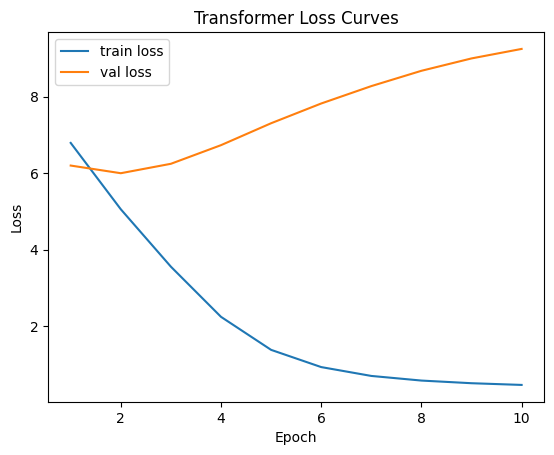

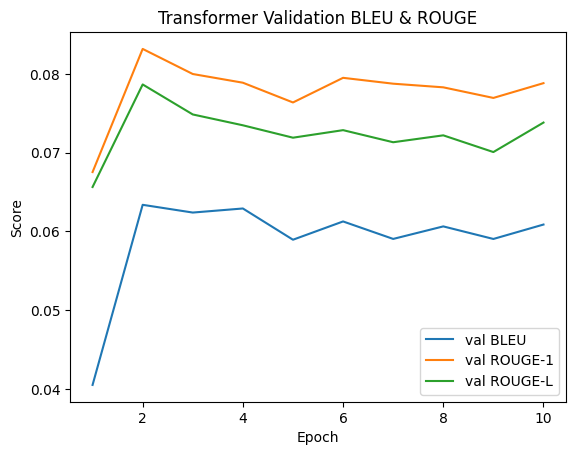

In [23]:
# Train & evaluate Transformer encoder–decoder
print("\n=== Training Transformer Encoder–Decoder ===")
transformer_model = train_transformer()

In [24]:
print("\n=== Evaluating Transformer on test set ===")
bleu_tr, r1_tr, rL_tr = evaluate_bleu_rouge(
    transformer_model, test_loader, tokenizer, DEVICE, MAX_LEN_HEADLINE, model_type="transformer"
)
print(f"Transformer Test BLEU: {bleu_tr:.4f}, ROUGE-1: {r1_tr:.4f}, ROUGE-L: {rL_tr:.4f}")


=== Evaluating Transformer on test set ===
Transformer Test BLEU: 0.0600, ROUGE-1: 0.0769, ROUGE-L: 0.0713


In [26]:
# Transformer headline generation
def generate_transformer_headline(model, article, max_len=MAX_LEN_HEADLINE):
    model.eval()
    # tokenize article
    enc = tokenizer(article, return_tensors="pt",
                    max_length=MAX_LEN_ARTICLE, truncation=True).to(DEVICE)
    src_ids  = enc["input_ids"]
    src_mask = enc["attention_mask"]
    # greedy decode
    dec_input = torch.full((1,1), BOS, dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        tgt_mask = torch.triu(torch.ones(dec_input.size(1), dec_input.size(1)),
                              diagonal=1).bool().to(DEVICE)
        logits = model(src_ids, src_mask, dec_input, tgt_mask)
        next_token = logits[:, -1, :].argmax(-1).unsqueeze(1)
        dec_input = torch.cat([dec_input, next_token], dim=1)
        if next_token.item() == EOS:
            break
    # filter out special tokens
    ids = [tok for tok in dec_input.squeeze().cpu().tolist() if tok not in {BOS, EOS, SEP, PAD}]
    return tokenizer.decode(ids, skip_special_tokens=False)

print("=== Generated Headlines ===")
for art in examples:
    print("\nArticle:", art)
    print("Transformers:", generate_transformer_headline(transformer_model, art))


=== Generated Headlines ===

Article: The stock market rallied today after strong earnings reports from the tech sector boosted investor confidence.
Transformers:  REUTERS POLLAL STOCKEDUNAR HeISPISPAREUMES REUTERS FullEDUN 

Article: Scientists have discovered a new species of frog in the Amazon rainforest that glows under ultraviolet light.
Transformers:  CEOs Dimon, Moyhn U.S. increased and Op pare insurance | in the state's State 

Article: The local soccer team secured their first championship in 20 years with a dramatic last-minute goal.
Transformers:  The home Best that P 6-year-old sales records 



=== Visualizing attention ===


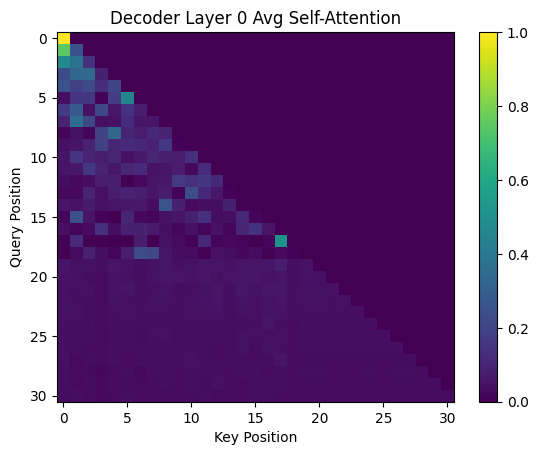

In [31]:
# Visualize self-attention for a test sample
print("\n=== Visualizing attention ===")
sample = next(iter(test_loader))
src_ids = sample["input_ids"][:1].to(DEVICE)
src_mask = sample["attention_mask"][:1].to(DEVICE)
tgt_in = sample["decoder_input_ids"][:1].to(DEVICE)
tgt_mask = torch.triu(torch.ones(tgt_in.size(1), tgt_in.size(1)), diagonal=1).bool().to(DEVICE)
logits, self_attns, cross_attns = transformer_model(
    src_ids, src_mask, tgt_in, tgt_mask, return_attentions=True
)
plot_attention(self_attns, layer=0)


In [36]:
# Finetune GPT-2
def train_gpt2():
    model = GPT2LMHeadModel.from_pretrained("gpt2").to(DEVICE)
    model.resize_token_embeddings(len(tokenizer))
    args = TrainingArguments(
        output_dir="gpt2_finetuned",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=3,
        learning_rate=5e-5,
        fp16=True,
        logging_steps=100,
        report_to="none",
        logging_dir="./logs"
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_gpt2_ds,
        eval_dataset=val_gpt2_ds,
        tokenizer=tokenizer
    )
    trainer.train()
    return model

In [37]:
# Fine-tune & evaluate GPT-2
print("\n=== Fine-tuning GPT-2 ===")
gpt2_model = train_gpt2()


=== Fine-tuning GPT-2 ===


<ipython-input-36-9f3d4a8e1977>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,7.939700
200,0.450800
300,0.207900
400,0.167100
500,0.170000
600,0.223000
700,0.146300
800,0.152500
900,0.184100
1000,0.154800


In [48]:
print("\n=== Evaluating GPT-2 on test set ===")
test_gpt2_loader = DataLoader(
    test_gpt2_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True
)
bleu_gpt2, r1_gpt2, rL_gpt2 = evaluate_bleu_rouge(
    gpt2_model, test_gpt2_loader, tokenizer, DEVICE,
    max_length=MAX_LEN_ARTICLE + MAX_LEN_HEADLINE, model_type="gpt2"
)
print(f"GPT-2 Test BLEU: {bleu_gpt2:.4f}, ROUGE-1: {r1_gpt2:.4f}, ROUGE-L: {rL_gpt2:.4f}")




=== Evaluating GPT-2 on test set ===
GPT-2 Test BLEU: 0.0448, ROUGE-1: 0.0771, ROUGE-L: 0.0771


In [49]:
# Finetuned GPT-2 headline generation
def generate_gpt2_headline(model, article, max_len=MAX_LEN_HEADLINE):
    model.eval()
    # build the prompt: BOS + article + SEP
    prompt = "<BOS> " + article + " <SEP>"
    enc = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=MAX_LEN_ARTICLE,
        truncation=True,
        padding="max_length"
    ).to(DEVICE)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]

    # generate up to max_len new tokens
    gen_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_len,
        eos_token_id=EOS,
        pad_token_id=PAD
    )
    # convert to list and locate SEP
    tokens = gen_ids[0].tolist()
    if SEP in tokens:
        sep_idx = tokens.index(SEP)
        headline_ids = tokens[sep_idx+1:]
    else:
        # fallback: drop BOS at position 0
        headline_ids = tokens[1:]

    # filter out any special tokens
    special_ids = {BOS, EOS, SEP, PAD}
    clean_ids = [tok for tok in headline_ids if tok not in special_ids]
    return tokenizer.decode(clean_ids, skip_special_tokens=False)

# print out some examples
print("=== Generated Headlines After GPT-2 Fine-tuning ===")
for art in examples:
    print("\nArticle:", art)
    print("GPT-2   :", generate_gpt2_headline(gpt2_model, art))


=== Generated Headlines After GPT-2 Fine-tuning ===

Article: The stock market rallied today after strong earnings reports from the tech sector boosted investor confidence.
GPT-2   :  Stock market rally: Tech stocks boost investor confidence 

Article: Scientists have discovered a new species of frog in the Amazon rainforest that glows under ultraviolet light.
GPT-2   :  A new species of frog is found in the Amazon rainforest 

Article: The local soccer team secured their first championship in 20 years with a dramatic last-minute goal.
GPT-2   :  Soccer's first championship in 20 years 


In [ ]:
# GUI, a small function that allows user to input and generate News Headlines.
import ipywidgets as widgets
from IPython.display import display, clear_output

# Model selector
model_dropdown = widgets.Dropdown(
    options=["Seq2Seq", "Transformer", "GPT-2"],
    value="Seq2Seq",
    description="Model:"
)

# Article input box
article_input = widgets.Textarea(
    description="Article:",
    layout=widgets.Layout(width='800px', height='120px')
)

# Generate button
generate_button = widgets.Button(
    description="Generate Headlines",
    button_style='primary'
)

# Output area
output_area = widgets.Output()

# Callback on button click
def on_generate_clicked(b):
    with output_area:
        clear_output()
        art = article_input.value.strip()
        if not art:
            print("Please enter an article or summary.")
            return

        model_name = model_dropdown.value
        print(f"=== {model_name} Generated Headlines ===")

        if model_name == "Seq2Seq":
            title = generate_seq2seq_headline(seq2seq_model, art)
            print(f"1. {title}")

        elif model_name == "Transformer":
            title = generate_transformer_headline(transformer_model, art)
            print(f"1. {title}")

        else:  # GPT-2
            prompt = "<BOS> " + art + " <SEP>"
            enc = tokenizer(
                prompt,
                return_tensors="pt",
                max_length=MAX_LEN_ARTICLE,
                truncation=True,
                padding="max_length"
            ).to(DEVICE)
            gen_ids = gpt2_model.generate(
                input_ids=enc["input_ids"],
                attention_mask=enc["attention_mask"],
                max_new_tokens=MAX_LEN_HEADLINE,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                num_return_sequences=1,
                eos_token_id=EOS,
                pad_token_id=PAD
            )
            for i, seq in enumerate(gen_ids):
                tokens = seq.tolist()
                sep_idx = tokens.index(SEP) if SEP in tokens else 0
                headline_ids = [tok for tok in tokens[sep_idx+1:] if tok not in {BOS, EOS, SEP, PAD}]
                title = tokenizer.decode(headline_ids, skip_special_tokens=False)
                print(f"{i+1}. {title}")

generate_button.on_click(on_generate_clicked)
ui = widgets.VBox([model_dropdown, article_input, generate_button, output_area])
display(ui)
